# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q paired with embedPy to carry out machine learning tasks. Below we demonstate how to train and test a random forest classifier using the Santander Customer Satisfaction dataset.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## EmbedPy

EmbedPy allows the kdb+/q interpreter to manipulate Python objects, call Python functions and load Python libraries. Python and kdb+/q developers can fuse both technologies together, allowing for a seamless application of kdb+/q’s high-speed analytics and Python’s rich ecosystem of libraries such as scikit-learn, Tensorflow, PyTorch and Theano.

## Classification Using Random Forests

The random forest algorithm is an ensemble learning method used for supervised classification and regression problems. Random Forests combine multiple decision trees and output an average prediction.

A random forest is a collection (often large) of decision trees, each fitted to a subset of the data. A standard choice for a subset is to randomly choose 50% of the datapoints (rows) and take $\sqrt[p]{p}$ of the  p  features (columns). A decision tree is fitted to each subset until the desired number of trees have been grown in the random forest.

The technique of fitting weakly-predictive models to subsets of the data is called bagging (bootstrap aggregation).

Random Forests can:
- Manage a mixture of discrete, continuous and categorical inputs.
- Use data with no normalization/pre-processing (including missing data).
- Incorporate a large number of trees without overfitting.

For these reasons, random forests are the preferred machine learning algorithm in many applications, even over neural networks.

Further discussion of Random Forests can be found in the Wikipedia article [Random forest](https://en.wikipedia.org/wiki/Random_forest) or [Sci-Kit Learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

## Santander Customer Satisfaction Data

The [Santander Customer Satisfaction Dataset](https://www.kaggle.com/c/santander-customer-satisfaction) is a database consisting of data from 76,020 Santander customers. There are 370 features for each customer, along with a field indicating whether they were satisfied customers or not.

---

### Load data
In the cell below, we load in the utilities library from the [ML-Toolkit](https://github.com/KxSystems/ml), along with graphics functions required for this notebook. We then use embedPy to import relevant python modules and load data from the Santander Customer Satisfaction dataset.

In [1]:
/ load toolkit and graphics functions
\l ml/ml.q
.ml.loadfile`:util/init.q

\l ../utils/graphics.q
\l ../utils/util.q

In [2]:
show 5#data:((370#"F"),"I";(),",")0:`:../data/santander.csv

/ Inspect data
-1"\nShape of feature data is: "," x "sv string .ml.shape delete TARGET from data;
-1"\nDistribution of target values:\n";
show update pcnt:.01*floor .5+10000*num%sum num from select num:count i by TARGET from data;

ID var3 var15 imp_ent_var16_ult1 imp_op_var39_comer_ult1 imp_op_var39_comer_u..
-----------------------------------------------------------------------------..
1  2    23    0                  0                       0                   ..
3  2    34    0                  0                       0                   ..
4  2    23    0                  0                       0                   ..
8  2    37    0                  195                     195                 ..
10 2    39    0                  0                       0                   ..

Shape of feature data is: 76020 x 370

Distribution of target values:

TARGET| num   pcnt 
------| -----------
0     | 73012 96.04
1     | 3008  3.96 


Classes are highly unbalanced:
- `96%` are satisfied (0)
- `4%` of clients are dissatisfied (1)

A classifier that naively predicted that all clients were satisfied, would therefore achieve nearly 96% accuracy on this dataset. However, such a model would not be of much use in predicting customer churn.

---

### Prepare data
Before we can train a model we need to split the original data into training and testing sets. In this notebook we have chosen to use a 67/33 train/test split.

In [3]:
\S 123  / random seed
show count each datadict:.ml.trainTestSplit[flip value flip delete TARGET from data;data`TARGET;.33]

xtrain| 50933
ytrain| 50933
xtest | 25087
ytest | 25087


---

### Fit and evaluate models
Here we create a function to build, fit and evaluate the classifiers.

In [4]:
score:{[y;ypred;yprob]
 `loss`acc`auc!(.ml.logLoss[y;yprob];.ml.accuracy[ypred;y];.ml.rocAucScore[y;yprob[;1]])}

results:{[data;clf;name;clfkwargs;ntrees]
 clf:rf[`n_estimators pykw ntrees;pykwargs clfkwargs];
 clf[`:fit][xnp:.util.npa data`xtrain;data`ytrain];
    
 ytrnprob:clf[`:predict_proba;<;xnp];
 ytrnpred:raze .ml.iMax each ytrnprob;
 ytstprob:clf[`:predict_proba;<;.util.npa data`xtest];
 ytstpred:raze .ml.iMax each ytstprob;
  
 trnscore:score[data`ytrain;ytrnpred;ytrnprob];
 tstscore:score[data`ytest ;ytstpred;ytstprob];
    
 -1 name," (",string[ntrees]," trees)";
 -1"Training log loss: ",string[trnscore`loss],", accuracy: ",raze[string trnscore`acc],", ROC: ",string trnscore`auc;
 -1"Testing  log loss: ",string[tstscore`loss],", accuracy: ",raze[string tstscore`acc],", ROC: ",string tstscore`auc;
 -1"\n";}

Now we will fit random forest classifiers with 1, 5, 10, 50 and 100 trees with a max depth of 80 on the training data and evaluate their performance on the held-out test data. 

In [5]:
rf:.p.import[`sklearn.ensemble]`:RandomForestClassifier
ntrees:1 5 10 50 100
rfkwargs:`class_weight`max_depth!(`balanced;80)
results[datadict;rf;"Random Forest Classifier";rfkwargs]each ntrees;

Random Forest Classifier (1 trees)
Training log loss: 0.8605365, accuracy: 0.9750849, ROC: 0.8361236
Testing  log loss: 2.402446, accuracy: 0.9304421, ROC: 0.5457468


Random Forest Classifier (5 trees)
Training log loss: 0.04032445, accuracy: 0.9913219, ROC: 0.9945875
Testing  log loss: 0.9307361, accuracy: 0.9541595, ROC: 0.6277713


Random Forest Classifier (10 trees)
Training log loss: 0.0298975, accuracy: 0.9928141, ROC: 0.9998577
Testing  log loss: 0.6865122, accuracy: 0.957468, ROC: 0.6890627


Random Forest Classifier (50 trees)
Training log loss: 0.02843851, accuracy: 0.9994699, ROC: 1
Testing  log loss: 0.338955, accuracy: 0.9576275, ROC: 0.7675127


Random Forest Classifier (100 trees)
Training log loss: 0.02823662, accuracy: 0.9999411, ROC: 1
Testing  log loss: 0.2636446, accuracy: 0.9581058, ROC: 0.7853519




---

### Results

Accuracy is significantly better on the training data than the test data. Near-perfect accuracy suggests that the model has effectively memorized the training dataset.

Given that the goal is to create a model which is able to generalize to unseen datasets, we must be wary of overfitting.

Below we plot the ROC curve for 100 trees to showcase model performance.

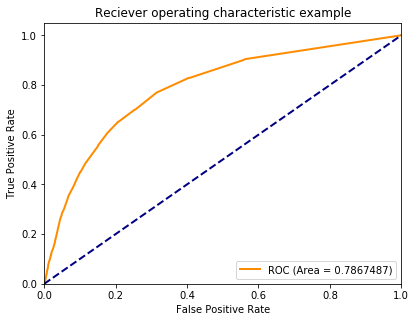

In [6]:
clf:rf[`n_estimators pykw 100;`max_depth pykw 100;`class_weight pykw`balanced];
clf[`:fit][datadict`xtrain;datadict`ytrain];
yprob:clf[`:predict_proba;<]datadict`xtest

.util.displayROC[datadict`ytest;yprob[;1]];

---

---

### Dealing with overfitting

Overfitting can be controlled by reducing the degree of freedom of the model, such as the depth of the trees that the algorithm constructs. We therefore repeat the exercise above, restricting the tree depth to 35.

In [7]:
rfkwargs:`class_weight`max_depth!(`balanced;35)
results[datadict;rf;"Random Forest Classifier";rfkwargs;]each ntrees;

Random Forest Classifier (1 trees)
Training log loss: 0.7343547, accuracy: 0.925078, ROC: 0.8562688
Testing  log loss: 1.725638, accuracy: 0.8942879, ROC: 0.6358734


Random Forest Classifier (5 trees)
Training log loss: 0.1309039, accuracy: 0.9422575, ROC: 0.9711166
Testing  log loss: 0.5770014, accuracy: 0.9137003, ROC: 0.7247115


Random Forest Classifier (10 trees)
Training log loss: 0.1044245, accuracy: 0.9610272, ROC: 0.9833968
Testing  log loss: 0.4477092, accuracy: 0.9284889, ROC: 0.7500404


Random Forest Classifier (50 trees)
Training log loss: 0.1093558, accuracy: 0.9553924, ROC: 0.9801622
Testing  log loss: 0.2645103, accuracy: 0.9229481, ROC: 0.7916468


Random Forest Classifier (100 trees)
Training log loss: 0.1115175, accuracy: 0.9556083, ROC: 0.9805392
Testing  log loss: 0.2095806, accuracy: 0.9221509, ROC: 0.805578




Similar testing results are seen in both models while generalising the model by restricting the tree depth.

Looking at the test results:
- The ROC measure is comparable to previous classifiers.
- The accuracy has reduced.

Looking again at the ROC curve for 100 trees:

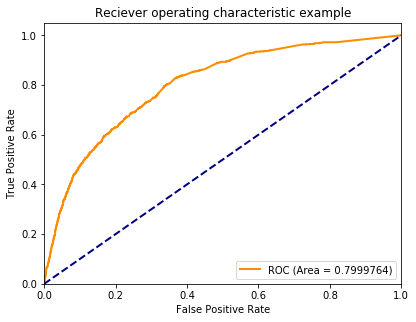

In [8]:
clf:rf[`n_estimators pykw 100;`max_depth pykw 35;`class_weight pykw`balanced];
clf[`:fit][datadict`xtrain;datadict`ytrain];
yprob:clf[`:predict_proba;<]datadict`xtest

.util.displayROC[datadict`ytest;yprob[;1]];

### XGBoost

XGBoost is a random forest algorithm that combines the bagging technique with a further addition called boosting.

Boosting works by increasing the weighting on examples that have been misclassified in the past.

Further information can be found on the [XGBoost website](https://xgboost.readthedocs.io/en/latest/).

We will repeat the process of training again with an XGB classifier to see how results are affected.

In [9]:
xgb:.p.import[`xgboost]`:XGBClassifier
rfkwargs:enlist[`max_depth]!enlist 4
results[datadict;xgb;"XGB Classifier";rfkwargs;]each ntrees;

XGB Classifier (1 trees)
Training log loss: 0.1565573, accuracy: 0.9606346, ROC: 0.6864871
Testing  log loss: 0.1603603, accuracy: 0.9598597, ROC: 0.6785125


XGB Classifier (5 trees)
Training log loss: 0.1470388, accuracy: 0.9606542, ROC: 0.7828502
Testing  log loss: 0.1496553, accuracy: 0.9600191, ROC: 0.7799746


XGB Classifier (10 trees)
Training log loss: 0.1462474, accuracy: 0.9606346, ROC: 0.7912313
Testing  log loss: 0.149036, accuracy: 0.9600191, ROC: 0.7836195


XGB Classifier (50 trees)
Training log loss: 0.1485095, accuracy: 0.9606346, ROC: 0.7994106
Testing  log loss: 0.1516814, accuracy: 0.9600191, ROC: 0.7908013


XGB Classifier (100 trees)
Training log loss: 0.1480589, accuracy: 0.9606346, ROC: 0.8013403
Testing  log loss: 0.1513638, accuracy: 0.9600191, ROC: 0.7930497




These results show a significant improvement, in terms of both accuracy and ROC scores.

Furthermore, plotting the ROC curve for 100 trees gives:

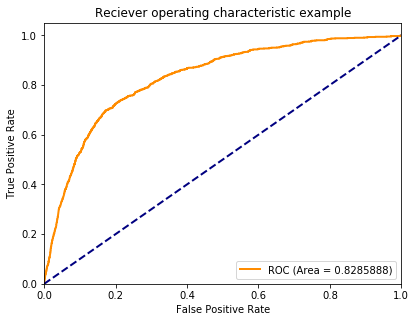

In [10]:
clf:xgb[`n_estimators pykw 100;`max_depth pykw 4];
clf[`:fit][.util.npa datadict`xtrain;.util.npa datadict`ytrain];
yprob:clf[`:predict_proba;<].util.npa datadict`xtest

.util.displayROC[datadict`ytest;yprob[;1]];

The XGB classifier with 100 trees attains a ROC value of 0.83. This is equal to the highest result recorded in Kaggle for this dataset.

---